In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 9 (Query Translation - HyDE)"

# Query translation

![](images/query-translation-01.png)

# Part 9: Query Translation - HyDE

![](images/09-hyde.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-bb337a70-0689-467c-b730-8da1af54be8f-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [14]:
from langchain_core.prompts import ChatPromptTemplate

In [15]:
hyde_prompt_template = """Please write a passage to answer the question
Question: {question}
Passage:"""
hyde_prompt = ChatPromptTemplate.from_template(hyde_prompt_template)
hyde_prompt.pretty_print()

================================ Human Message =================================

Please write a passage to answer the question
Question: {question}
Passage:


In [16]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
rag_prompt = ChatPromptTemplate.from_template(rag_prompt_template)
rag_prompt.pretty_print()

================================ Human Message =================================

Answer the following question based on this context:

{context}

Question: {question}



In [17]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [18]:
query = "What is task decomposition for LLM agents?"

### LangChain

In [19]:
from functools import partial

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import chain, RunnableConfig, RunnableParallel, RunnablePassthrough
import numpy as np

#### Define retrieval chain

In [20]:
@chain
def generate_documents(query: str, config: RunnableConfig) -> list[Document]:
    generated_documents_count = config['configurable'].get("generated_documents_count", 3)
    chain = (
        hyde_prompt
        | llm
        | StrOutputParser()
    )
    generated_documents = chain.batch([{'question': query}] * generated_documents_count)
    return generated_documents

rprint(generate_documents.invoke(query))

[
    'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex tasks 
into smaller, more manageable subtasks that an LLM can handle effectively. This approach is essential in maximizing
the efficiency and effectiveness of LLMs, especially when faced with intricate or multifaceted queries. By 
decomposing a larger task, the model can focus on one aspect at a time, thereby reducing the cognitive load and 
potential for errors.\n\nFor instance, if the overall task is to generate a research report, task decomposition 
would involve identifying and tackling subtasks such as gathering relevant information, outlining key sections, 
drafting individual paragraphs, and formatting the final document. Each of these subtasks can be addressed 
sequentially or in parallel, allowing the LLM to leverage its strengths in language understanding and generation in
a more structured manner.\n\nTask decomposition also facilitates better interaction with users, as it allows the 
LLM to provide iterative feedback or partial results, thereby enhancing the collaborative process. This method not 
only improves the overall quality of the output but also aids in clarifying user intentions and expectations, 
leading to more satisfactory outcomes. In summary, task decomposition is a strategic approach that empowers LLM 
agents to manage complexity by converting challenging problems into simpler, actionable components.',
    'Task decomposition for Large Language Model (LLM) agents refers to the process of breaking down complex tasks 
into smaller, more manageable subtasks that can be more easily understood and executed by the model. This approach 
leverages the capabilities of LLMs to analyze and generate language in a structured manner, enabling more effective
problem-solving and decision-making.\n\nIn practice, task decomposition involves identifying the key components of 
a larger task and articulating them clearly. For example, if the overarching goal is to generate a research paper, 
decomposition might involve subtasks such as selecting a topic, conducting a literature review, outlining the 
structure, drafting individual sections, and finally editing the content. By systematically tackling each subtask, 
the LLM can produce higher quality outputs and maintain coherence throughout the project.\n\nFurthermore, task 
decomposition can enhance collaboration between LLM agents and users, allowing for iterative feedback and 
adjustments at each stage of the process. This method also facilitates the integration of external resources, such 
as databases or APIs, to gather information relevant to specific subtasks, thereby enriching the overall output. 
Ultimately, effective task decomposition not only improves the efficiency of LLM agents but also harnesses their 
language processing power to deliver more precise and relevant results.',
    "Task decomposition for Large Language Model (LLM) agents refers to the process of breaking down complex tasks 
into smaller, manageable sub-tasks that the LLM can handle more effectively. This approach is vital for enhancing 
the performance and efficiency of LLMs when addressing intricate problems or queries. By segmenting a larger task 
into simpler components, the LLM can leverage its strengths in understanding and generating language while focusing
on one aspect of the task at a time.\n\nFor example, if the overall task is to draft a research paper, task 
decomposition might involve dividing it into sub-tasks such as conducting a literature review, outlining key 
sections, drafting individual paragraphs, and revising content for clarity and coherence. Each of these smaller 
tasks can be tackled sequentially or in parallel, allowing the agent to produce more focused and coherent 
outputs.\n\nMoreover, task decomposition facilitates better resource management, as it allows LLMs to optimize 
their processing capabilities and memory usage by concentrating on one part of the

In [21]:
rprint(generate_documents.with_config(generated_documents_count=5).invoke(query))

[
    "Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex tasks 
or problems into smaller, more manageable sub-tasks. This approach is critical for enhancing the efficiency and 
effectiveness of LLMs in performing intricate tasks that require multi-step reasoning or diverse forms of knowledge
application. By subdividing a larger task, LLM agents can focus on solving each component separately, allowing for 
greater clarity, improved organization, and more effective use of the model's capabilities.\n\nFor instance, when 
tasked with generating a project proposal, an LLM might decompose this into specific sub-tasks such as researching 
background information, outlining the structure of the proposal, drafting individual sections, and refining the 
final document. Each sub-task can be approached sequentially or iteratively, leveraging the model's ability to 
handle natural language processing, comprehension, and generation at a granular level. This systematic breakdown 
not only aids in the efficient management of the overall task but also reduces the likelihood of errors and 
enhances the quality of the final output. Overall, task decomposition empowers LLM agents to tackle complex queries
and applications with greater precision and efficacy.",
    "Task decomposition for large language model (LLM) agents refers to the process of breaking down complex tasks 
into smaller, more manageable sub-tasks. This approach allows the LLM to tackle intricate problems by focusing on 
specific components, rather than attempting to solve the entire task in one go. By dividing tasks into discrete 
steps, LLM agents can leverage their capabilities more effectively, enhancing their understanding and improving the
quality of their responses.\n\nFor instance, when assigned a multi-step question—such as planning an event—task 
decomposition would involve identifying individual aspects, such as venue selection, guest lists, catering, and 
scheduling. The LLM could then address each sub-task systematically, ensuring that each element is thoroughly 
considered. This method not only increases the clarity of the agent's output but also allows for iterative 
refinement, as the agent can evaluate each completed sub-task before moving onto the next.\n\nAdditionally, task 
decomposition can help LLM agents manage resources more efficiently, facilitating better allocation of 
computational power and time. In collaborative scenarios, it can also enhance teamwork among multiple agents by 
clearly defining roles and responsibilities. Overall, task decomposition is a vital strategy that enables LLM 
agents to handle complexity with greater precision and efficacy, ultimately leading to improved problem-solving 
outcomes.",
    'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down a complex task
or problem into smaller, more manageable sub-tasks that can be addressed sequentially or in parallel. This 
technique is essential for enhancing the efficiency and effectiveness of LLM agents, allowing them to tackle 
intricate queries by focusing on individual components rather than attempting to solve everything at once.\n\nBy 
segmenting tasks, LLM agents can leverage their language understanding capabilities more effectively, applying 
reasoning and generating appropriate responses for each sub-task. For example, if an agent is tasked with writing a
research paper, task decomposition might involve first identifying the key topics, outlining the structure, 
conducting literature reviews, and then drafting sections. Each of these subtasks can be approached independently, 
ensuring that the agent maintains clarity and coherence throughout the overall task execution.\n\nAdditionally, 
task decomposition allows LLM agents to prioritize and manage their outputs more easily. By clarifying the 
relationships between sub-tasks, agents can also better allocate computational resources, en

In [22]:
def calculate_hyde_embeddings(hyde_components):
    question_embeddings = np.array(embeddings.embed_query(hyde_components['question']))
    generated_documents_embeddings = np.array(embeddings.embed_documents(hyde_components['generated_documents']))
    hyde_embeddings = np.vstack([question_embeddings, generated_documents_embeddings]).mean(axis=0)
    return hyde_embeddings

def get_relevant_documents(hyde_embeddings):
    return vectorstore.similarity_search_by_vector(hyde_embeddings)

In [23]:
retrieval_chain =  (
    RunnableParallel({
        'question': RunnablePassthrough(),
        'generated_documents': generate_documents
    })
    | calculate_hyde_embeddings
    | get_relevant_documents
)

rprint(query)
docs = retrieval_chain.invoke(query)
rprint(docs)

What is task decomposition for LLM agents?

[
    Document(
        id='85a96e8b-b7fc-4d1d-89f2-aaa03fe355a4',
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA 
complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask 
Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing 
model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time 
computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple 
manageable tasks and shed lights into an interpretation of the model’s thinking process.'
    ),
    Document(
        id='11e40a49-f0a3-454b-8fbe-ccf99bad696d',
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  
|  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool 
concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. 
The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be 
framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM
functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: 
The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex 
tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn 
from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
    ),
    Document(
        id='f0a0f781-621f-4922-ab59-92600a129f5c',
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Reliability of natural language interface: Current agent system relies on natural language as
an interface between LLMs and external components such as memory and tools. However, the reliability of model 
outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior (e.g. 
refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
    ),
    Document(
        id='d18c90b6-9746-447c-a09d-f6407b460b0b',
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='(4) Response generation: LLM receives the execution results and provides summarized results 
to users.\nTo put HuggingGPT into real world usage, a couple challenges need to solve: (1) Efficiency improvement 
is needed as both LLM inference rounds and interactions with other models slow down the process; (2) It relies on a
long context window to communicate over complicated task content; (3) Stability improvement of LLM outputs and 
external model services.'
    )
]

In [24]:
rprint(query)

chunk_pattern = re.compile(r'^Chunk \d+.*:$', flags=re.MULTILINE)
terms_pattern = re.compile(rf'\b({"|".join(query.split())})\b', flags=re.IGNORECASE)

for chunk_id, doc in enumerate(docs, start=1):
    text = Text(f"Chunk {chunk_id}:\n{doc.page_content}")
    text.highlight_regex(chunk_pattern, "bold green")
    text.highlight_regex(terms_pattern, "underline red")
    rprint(text)

What is task decomposition for LLM agents?

Chunk 1:
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance 
on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to 
decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and 
shed lights into an interpretation of the model’s thinking process.

Chunk 2:
LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts
demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends 
beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem
solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key 
components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient 
handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from 
mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Chunk 3:
Reliability of natural language interface: Current agent system relies on natural language as an interface between 
LLMs and external components such as memory and tools. However, the reliability of model outputs is questionable, 
as LLMs may make formatting errors and occasionally exhibit rebellious behavior (e.g. refuse to follow an 
instruction). Consequently, much of the agent demo code focuses on parsing model output.


Citation#
Cited as:

Weng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.

Chunk 4:
(4) Response generation: LLM receives the execution results and provides summarized results to users.
To put HuggingGPT into real world usage, a couple challenges need to solve: (1) Efficiency improvement is needed as
both LLM inference rounds and interactions with other models slow down the process; (2) It relies on a long context
window to communicate over complicated task content; (3) Stability improvement of LLM outputs and external model 
services.

#### Define RAG chain

In [25]:
rag_chain = (
    {
        "context": retrieval_chain | format_docs,
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)

rprint(query)
response = rag_chain.invoke(query)
Markdown(response)

What is task decomposition for LLM agents?

Task decomposition for LLM agents involves breaking down large, complex tasks into smaller, manageable subgoals.   
This process enables the agent to handle tasks more efficiently by transforming big tasks into multiple simpler    
steps. A common technique used for task decomposition is Chain of Thought (CoT), where the model is prompted to    
"think step by step," helping to clarify and interpret the model's thinking process. Additionally, decomposition   
can be achieved through simple prompting, task-specific instructions, or human inputs, allowing the agent to       
systematically approach and solve challenges.

### LangGraph

In [26]:
from typing import Annotated, TypedDict

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
import numpy as np

In [27]:
class State(TypedDict):
    question: str
    generated_documents: list[str]
    hyde_embeddings: np.ndarray
    context: list[Document]
    answer: str

In [28]:
def generate_documents(state: State, config: RunnableConfig) -> list[Document]:
    generated_documents_count = config['configurable'].get("generated_documents_count", 3)
    
    chain = (
        hyde_prompt
        | llm
        | StrOutputParser()
    )
    generated_documents = chain.batch([{'question': state["question"]}] * generated_documents_count)
    
    return {"generated_documents": generated_documents}


def calculate_hyde_embeddings(state: State):
    question_embeddings = np.array(embeddings.embed_query(state['question']))
    generated_documents_embeddings = np.array(embeddings.embed_documents(state['generated_documents']))
    hyde_embeddings = np.vstack([question_embeddings, generated_documents_embeddings]).mean(axis=0)
    return {"hyde_embeddings": hyde_embeddings}

def get_relevant_documents(state: State):
    documents = vectorstore.similarity_search_by_vector(state["hyde_embeddings"])
    return {"context": documents}

def generate_answer(state: State):
    docs_content = format_docs(state["context"])
    chain = rag_prompt | llm | StrOutputParser()
    response = chain.invoke(
        {
            "question": state["question"], 
            "context": docs_content
        }
    )
    return {"answer": response}

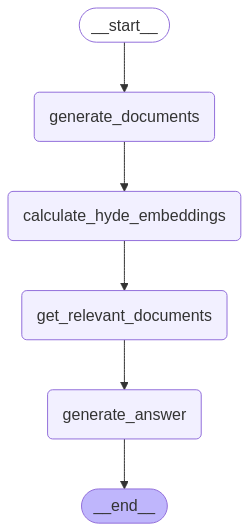

In [29]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_documents", generate_documents)
graph_builder.add_node("calculate_hyde_embeddings", calculate_hyde_embeddings)
graph_builder.add_node("get_relevant_documents", get_relevant_documents)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_documents")
graph_builder.add_edge("generate_documents", "calculate_hyde_embeddings")
graph_builder.add_edge("calculate_hyde_embeddings", "get_relevant_documents")
graph_builder.add_edge("get_relevant_documents", "generate_answer")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()
graph

In [30]:
print(query)

response = graph.invoke({"question": query})

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_documents': [
        'Task decomposition for large language model (LLM) agents refers to the process of breaking down complex 
tasks into simpler, more manageable sub-tasks that can be tackled individually. This technique enhances the 
efficiency and effectiveness of LLMs by allowing them to focus on specific components of a problem rather than 
attempting to solve it all at once. For instance, if an LLM is tasked with writing a research paper, task 
decomposition would involve identifying and delineating various stages such as topic selection, literature review, 
data analysis, and drafting. By addressing each stage separately, the LLM can generate more coherent and focused 
outputs, ultimately leading to a higher quality end result. Task decomposition not only aids in organizational 
clarity but also allows for better resource allocation and error management, ensuring that each sub-task receives 
the appropriate attention and expertise needed to achieve optimal performance.',
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks into smaller, more manageable subtasks to enhance problem-solving efficiency and effectiveness. This approach
allows LLMs to tackle intricate challenges by addressing each subtask individually, rather than attempting to solve
the entire problem in one go. \n\nBy decomposing tasks, LLMs can leverage their language understanding capabilities
more effectively, ensuring that they handle specific aspects of a problem with greater accuracy. For instance, in a
multi-step reasoning scenario, task decomposition allows the agent to first identify the key components of the 
problem, organize these components logically, and then address them sequentially. This strategy not only improves 
the clarity of the solution but also enables the model to provide coherent and structured responses. \n\nMoreover, 
task decomposition can facilitate collaboration among multiple LLM agents, where each agent takes on different 
subtasks, leading to faster and more efficient completion of the overall task. This approach mirrors human 
problem-solving strategies, making LLM agents more versatile and capable in a variety of applications, from natural
language processing to complex decision-making tasks.',
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks into smaller, more manageable components that can be addressed individually. This approach enhances the 
efficiency and effectiveness of LLMs in executing multifaceted requests by structuring the workflow into distinct 
stages or subtasks. \n\nFor instance, if an LLM is tasked with summarizing a lengthy article, task decomposition 
would involve identifying key elements such as main ideas, supporting arguments, and conclusions. By processing 
each of these components separately, the model can produce a coherent and concise summary that captures the essence
of the article without losing important details. \n\nAdditionally, task decomposition allows LLM agents to leverage
their capabilities in a more targeted manner, enabling more accurate responses and reducing the cognitive load on 
the model. This method is particularly beneficial when dealing with intricate tasks that require critical thinking,
creativity, or problem-solving, as it allows the model to focus on one aspect at a time, improving overall accuracy
and quality of the output. Ultimately, effective task decomposition is a vital strategy for enhancing the 
performance and utility of LLM agents in diverse applications.'
    ],
    'hyde_embeddings': array([0.00799526, 0.01970467, 0.04962153, ..., 0.01382141, 0.00146945,
       0.01720253]),
    'context': [Document(...), Document(...), Document(...), Document(...)],
    'answer': 'Task decomposition for LLM agents refers to the process of breaking down large and

Task decomposition for LLM agents refers to the process of breaking down large and complex tasks into smaller,     
manageable subgoals, which allows the agent to handle the tasks more efficiently. This method enhances the overall 
performance of the model by utilizing a technique known as Chain of Thought (CoT), where the agent is prompted to  
"think step by step." This approach not only transforms big tasks into simpler components but also provides        
insights into the model's thought process. Additionally, task decomposition can be achieved through various        
methods, including simple prompting, task-specific instructions, or human inputs. Overall, task decomposition      
enables a structured approach to problem-solving within LLM-powered autonomous agents.

In [31]:
print(query)

config = {
    "configurable": {
        "generated_documents_count": 5,   
    }
}
response = graph.invoke({"question": query}, config=config)

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_documents': [
        "Task decomposition for large language model (LLM) agents refers to the process of breaking down complex 
tasks into smaller, manageable sub-tasks that can be addressed more effectively by the model. This technique 
enhances the model's ability to tackle multifaceted problems by simplifying them into discrete components that are 
easier to understand and solve. \n\nIn practice, task decomposition involves identifying the various elements that 
contribute to the overall goal and analyzing their relationships. For example, if the main task is to write a 
research paper, task decomposition might include sub-tasks such as conducting literature review, formulating a 
thesis statement, creating an outline, drafting sections, and editing the final document. By tackling each sub-task
individually, the LLM can provide more targeted responses and improve the quality of the output.\n\nThis approach 
also allows for leveraging the strengths of the LLM more effectively, as it can draw upon its vast knowledge base 
to address specific inquiries related to each smaller task. Furthermore, task decomposition makes it easier for 
human collaborators to guide the LLM, provide feedback, and ensure that the overall task stays aligned with the 
intended objectives. Ultimately, effective task decomposition can lead to more coherent, comprehensive, and 
high-quality responses from LLM agents.",
        "Task decomposition for large language model (LLM) agents refers to the process of breaking down complex 
tasks into smaller, more manageable subtasks that can be more easily addressed by the model. This strategy helps 
maximize the efficiency and effectiveness of the LLM in handling intricate problems or queries that may be beyond 
its immediate processing capabilities. \n\nBy segmenting a task into its constituent parts, LLM agents can focus on
each segment individually, thereby ensuring that they generate more accurate and relevant responses. For example, 
if an LLM is tasked with creating a research report, task decomposition would involve identifying initial steps 
such as conducting background research, outlining the report’s structure, drafting individual sections, and 
ultimately reviewing and editing the final output. \n\nThis structured approach not only allows for parallel 
processing of subtasks—where different aspects of the task can be addressed simultaneously—but also facilitates 
better organization and clarity in the model's outputs. Furthermore, task decomposition enables iterative 
refinement, where the results of one subtask can inform and improve subsequent tasks, leading to a cohesive final 
product. Overall, task decomposition enhances the capability of LLM agents to tackle large and complex inquiries by
transforming them into simpler, actionable components.",
        "Task decomposition for Large Language Model (LLM) agents refers to the process of breaking down complex 
tasks into smaller, more manageable subtasks that can be handled individually. This technique leverages the LLM's 
capabilities to understand and generate human-like text, enabling it to tackle multifaceted problems in a 
systematic way. By dissecting a larger objective into discrete elements, LLM agents can focus on each component, 
apply relevant knowledge or reasoning, and generate clearer, more effective responses.\n\nFor instance, if an LLM 
agent is assigned the task of drafting a research paper, task decomposition would involve identifying the key steps
necessary for completion, such as conducting a literature review, outlining the structure, writing individual 
sections, and formatting the final document. By approaching the task in this segmented manner, the agent can 
improve its efficiency and enhance the quality of the output, as it can utilize its deep understanding of each 
subtask independently before synthesizing them into a cohesive final product.

Task decomposition for LLM (large language model) agents involves breaking down large and complex tasks into       
smaller, manageable subgoals. This approach enhances the agent's ability to handle complicated tasks by allowing it
to focus on simpler steps, facilitating a clearer planning and execution process. The technique, often referred to 
as Chain of Thought (CoT), encourages the model to "think step by step," promoting a more structured and           
interpretable thinking process. By decomposing tasks into smaller components, LLM agents can improve their         
problem-solving efficiency and effectiveness.